In [81]:
# This cells is used  to install modules
# !pip install propy3
# !pip install rdkit

In [82]:
# EDA and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Tools

from rdkit import Chem
from rdkit.Chem import AllChem
from Bio import SeqIO # Python tool for Computational Molecular Biology
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from protlearn.preprocessing import integer_encode
from propy.GetProteinFromUniprot import GetProteinSequence
from propy.CTD import CalculateCTD

# model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metric, score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# statistics
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

Reference:
1. Bhadra, P., Yan, J., Li, J. et al. AmPEP: Sequence-based prediction of antimicrobial peptides using distribution patterns of amino acid properties and random forest. Sci Rep 8, 1697 (2018). https://doi.org/10.1038/s41598-018-19752-w
2. Yan J, Bhadra P, Li A, Sethiya P, Qin L, Tai HK, Wong KH, Siu SWI. Deep-AmPEP30: Improve Short Antimicrobial Peptides Prediction with Deep Learning. Mol Ther Nucleic Acids. 2020 Jun 5;20:882-894. doi: 10.1016/j.omtn.2020.05.006. Epub 2020 May 12. PMID: 32464552; PMCID: PMC7256447.
3. https://propy3.readthedocs.io/en/latest/index.html
    

Features:
- 'average_polarity'
- 'size'
- 'hydrophobicity'
- 'molecular_weight'
- 'charge'
- 'second_structure':
  - 'helix_frac'
  - 'turn_frac'
  - 'sheet_frac'
- 'CTD':
  - Compute the composition, transition, and distribution descriptors based on the different properties of AADs (Properties: NormalizedVDWV, Hydrophobicity, Polarity, Polarizability, SecondaryStr, SolventAccessibility, Charge) from Reference 2


### Load peptide sequence from fasta to DataFrame

In [83]:
# SeqIO: Read fasta
fasta = "train_po_ne.fasta"
records = list(SeqIO.parse(fasta, "fasta"))

# Extract info from fasta, convert to DataFrame
data = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}

train = pd.DataFrame(data)

In [84]:
train

,Description,Sequence
0,amp5_30_1,ACSAG
1,amp5_30_2,AMVGT
2,amp5_30_3,AMVSS
3,amp5_30_4,CPFVC
4,amp5_30_5,SPGGA
...,...,...
3053,nonamp5_30_1525,GWKDWLNKGKEWLKKKGPGIMKAALKAATQ
3054,nonamp5_30_1526,GLFKTLIKGAGKMLGHVAKQFLGSQGQPES
3055,nonamp5_30_1527,GIPCGESCVYIPCTVTALAGCKCKSKVCYN
3056,nonamp5_30_1528,SFSVNPAVDILQHRYMEKVAQNNRNFLNRV


In [85]:
fasta = "test_po.fasta"
records = list(SeqIO.parse(fasta, "fasta"))
test_po = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}

df_test_po = pd.DataFrame(test_po)

In [86]:
df_test_po

,Description,Sequence
0,test_po_80cdhit_1,ETWRTEAPSATGQASSLLGGRLLGQ
1,test_po_80cdhit_2,LGGIVSAVKKIVDFLG
2,test_po_80cdhit_3,GRKKRRQRRRGGWMWVTNLRTD
3,test_po_80cdhit_4,FAKLAKKALAKLL
4,test_po_80cdhit_5,KIAKVALAKLGIGAVLKVLTTGL
...,...,...
89,test_po_80cdhit_90,KAQIRAMECNIL
90,test_po_80cdhit_91,LRVRLASHLRKLRKRLLRDADDLQKRLAVY
91,test_po_80cdhit_92,VNWKKIILGKIIKVVK
92,test_po_80cdhit_93,PAARKAARWAWRMLKKGA


In [87]:
fasta = "test_ne.fasta"
records = list(SeqIO.parse(fasta, "fasta"))
test_ne = {'Description': [record.description for record in records],
        'Sequence': [str(record.seq) for record in records]}
df_test_ne = pd.DataFrame(test_ne)

In [88]:
df_test_ne

,Description,Sequence
0,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,NYIYSGHNYHQ
1,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,DPNATIIMLGTGTGIAPFR
2,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MGQGAVEGQLFYNVQ
3,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSQASSSPGEGPSSEAAAISEAEAASGS
4,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,INWKKIASIGKEVLKAL
...,...,...
89,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,ALPNQQTVDYPSFKSNYNFEKPFLYLAR
90,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,AGFVLKGYTKTSQ
91,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,VNQSETPVKHIGKVF
92,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSDELIHVVIALGLVISFGLGAITAGVLR


In [89]:
df_test_ne.iloc[0,0]

'unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_ampepTr_cdh8_sample94_1'

In [90]:
test = pd.concat([df_test_po, df_test_ne], ignore_index=True)

In [91]:
test

,Description,Sequence
0,test_po_80cdhit_1,ETWRTEAPSATGQASSLLGGRLLGQ
1,test_po_80cdhit_2,LGGIVSAVKKIVDFLG
2,test_po_80cdhit_3,GRKKRRQRRRGGWMWVTNLRTD
3,test_po_80cdhit_4,FAKLAKKALAKLL
4,test_po_80cdhit_5,KIAKVALAKLGIGAVLKVLTTGL
...,...,...
183,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,ALPNQQTVDYPSFKSNYNFEKPFLYLAR
184,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,AGFVLKGYTKTSQ
185,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,VNQSETPVKHIGKVF
186,unip30_cdh10_stdif_dpAmpepTr30_iamp2l_ampScan_...,MSDELIHVVIALGLVISFGLGAITAGVLR


### Preprocessing

In [92]:
# Train dataset

In [93]:
# Convert 'Description' to Label
train['Label'] = train['Description'].apply(lambda x: 0 if 'non' in x else 1)
train = train.drop(columns='Description')

In [94]:
train

,Sequence,Label
0,ACSAG,1
1,AMVGT,1
2,AMVSS,1
3,CPFVC,1
4,SPGGA,1
...,...,...
3053,GWKDWLNKGKEWLKKKGPGIMKAALKAATQ,0
3054,GLFKTLIKGAGKMLGHVAKQFLGSQGQPES,0
3055,GIPCGESCVYIPCTVTALAGCKCKSKVCYN,0
3056,SFSVNPAVDILQHRYMEKVAQNNRNFLNRV,0


In [95]:
# Test dataset

In [96]:
# Convert 'Description' to Label
test['Label'] = test['Description'].apply(lambda x: 1 if 'po' in x else 0)
test = test.drop(columns='Description')

In [97]:
test

,Sequence,Label
0,ETWRTEAPSATGQASSLLGGRLLGQ,1
1,LGGIVSAVKKIVDFLG,1
2,GRKKRRQRRRGGWMWVTNLRTD,1
3,FAKLAKKALAKLL,1
4,KIAKVALAKLGIGAVLKVLTTGL,1
...,...,...
183,ALPNQQTVDYPSFKSNYNFEKPFLYLAR,0
184,AGFVLKGYTKTSQ,0
185,VNQSETPVKHIGKVF,0
186,MSDELIHVVIALGLVISFGLGAITAGVLR,0


In [98]:
total_data = pd.concat([train, test], ignore_index=True)

In [99]:
total_data

,Sequence,Label
0,ACSAG,1
1,AMVGT,1
2,AMVSS,1
3,CPFVC,1
4,SPGGA,1
...,...,...
3241,ALPNQQTVDYPSFKSNYNFEKPFLYLAR,0
3242,AGFVLKGYTKTSQ,0
3243,VNQSETPVKHIGKVF,0
3244,MSDELIHVVIALGLVISFGLGAITAGVLR,0


In [100]:
# X = total_data.drop(columns='Label')
X = total_data
y = total_data['Label']

test_size = 0.2
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [101]:
X_train.shape

(2596, 2)

In [102]:
X_train

,Sequence,Label
0,GHHPHGHHPHGHHPHGHHHPH,1
1,YVPPVQKPHPNGPKFPTFP,1
2,GLPCGESCVFIPCITTVVGCSCKNKVCYND,0
3,PFNVGGLDKFGTLN,0
4,WWRELLKKLAFTAAGHLGSVLAAKQSGW,0
...,...,...
2591,IDPFVAGVAAEMMQHVYCAASKKC,1
2592,ADPTFGFTPLGLSEKANLQIMKAYD,1
2593,GLFLDTLKGLAGKLLQGLKCIKAGCKP,1
2594,TCESPSHKFKGPCATNRNCES,1


In [103]:
y_train

0       1
1       1
2       0
3       0
4       0
       ..
2591    1
2592    1
2593    1
2594    1
2595    0
Name: Label, Length: 2596, dtype: int64

### Feature Engineering

In [104]:
class Property_Transformer(object):
    
    def __init__(self):
        # Polarity values for amino acids (1 for polar, 0 for nonpolar)
        self.polarity_values = {'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0, 'H': 1, 'I': 0,
                                'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1, 'T': 1, 'W': 0, 'Y': 1, 'V': 0}
        
        # reference: charge_values = {'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5, 'other aa':0}, charge result is the sum of all the values

        
    def fit(self, X, y=None):
        pass # No training needed
        
    def transform(self, X, y=None):
        X['average_polarity'] = X['Sequence'].apply(self.calculate_average_polarity)
        X['size'] = X['Sequence'].apply(len)
        X['hydrophobicity'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy()) 
        X['molecular_weight'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())
        X['charge'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).charge_at_pH(7.0))
        X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
        X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
        X[['helix_frac', 'turn_frac', 'sheet_frac']] = X['second_structure'].apply(pd.Series) # split the 'second_structure' column into 3 new columns
        X = X.drop(columns=['Sequence', 'second_structure'])
        return X
    
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def calculate_average_polarity(self, sequence):
        # Calculate polarity for each amino acid in the sequence
        polarities = [self.polarity_values.get(aa, 0) for aa in sequence]
        average_polarity = sum(polarities) / len(sequence)
        return average_polarity
    
    def calculate_normalized_vdw_energy(self, sequence):
        # Convert the peptide sequence to a molecule
        mol = Chem.MolFromSmiles(sequence)
        
        # Compute 3D coordinates
        AllChem.EmbedMolecule(mol)
        
        # Calculate van der Waals energy
        vdw_energy = AllChem.MMFFGetMoleculeForceField(mol).CalcEnergy()

        # Normalize the energy based on the number of atoms in the molecule
        normalized_vdw_energy = vdw_energy / mol.GetNumAtoms()

        return normalized_vdw_energy

In [105]:
ptf = Property_Transformer()
transformed_train = ptf.fit_transform(X_train)
transformed_train

,Label,average_polarity,size,hydrophobicity,molecular_weight,charge,helix_frac,turn_frac,sheet_frac
0,1,0.619048,21,-2.361905,2417.4922,0.893366,0.000000,0.380952,0.000000
1,1,0.368421,19,-0.926316,2147.4754,1.844279,0.105263,0.473684,0.315789
2,0,0.566667,30,0.563333,3153.7144,-0.295189,0.133333,0.333333,0.366667
3,0,0.357143,14,-0.035714,1478.6470,-0.041349,0.214286,0.500000,0.428571
4,0,0.357143,28,0.085714,3125.6248,2.847079,0.500000,0.178571,0.392857
...,...,...,...,...,...,...,...,...,...
2591,1,0.416667,24,0.504167,2570.0385,-0.171592,0.416667,0.166667,0.250000
2592,1,0.440000,25,-0.160000,2728.0795,-1.198890,0.400000,0.320000,0.360000
2593,1,0.370370,27,0.433333,2786.4452,3.736425,0.518519,0.259259,0.370370
2594,1,0.761905,21,-1.180952,2296.5199,0.459281,0.238095,0.380952,0.142857


In [106]:
transformed_train.shape

(2596, 9)

### EDA

In [113]:
def plot_histograms(dataframe):
#     sns.set(style="darkgrid")
#     dataframe = dataframe.drop(columns=['Sequence', 'second_structure'])
    features = dataframe.columns.tolist()
    features.remove('Label')

    # Set the number of subplots and their arrangement
    num_subplots = len(features)
    num_cols = 3  # You can change the number of columns based on your preference
    num_rows = (num_subplots - 1) // num_cols + 1

    # Set the size of the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    # Flatten axes in case there is only one row
    axes = axes.flatten()

    # Loop through each column and plot the histogram
    for i, column in enumerate(features):
        ax = axes[i]
        sns.histplot(data=dataframe[dataframe.Label==1], x=column, ax=ax, edgecolor='none')
        sns.histplot(data=dataframe[dataframe.Label==0], x=column, ax=ax, color='y', edgecolor='none')
        ax.set_title(f'{column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')

    # remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

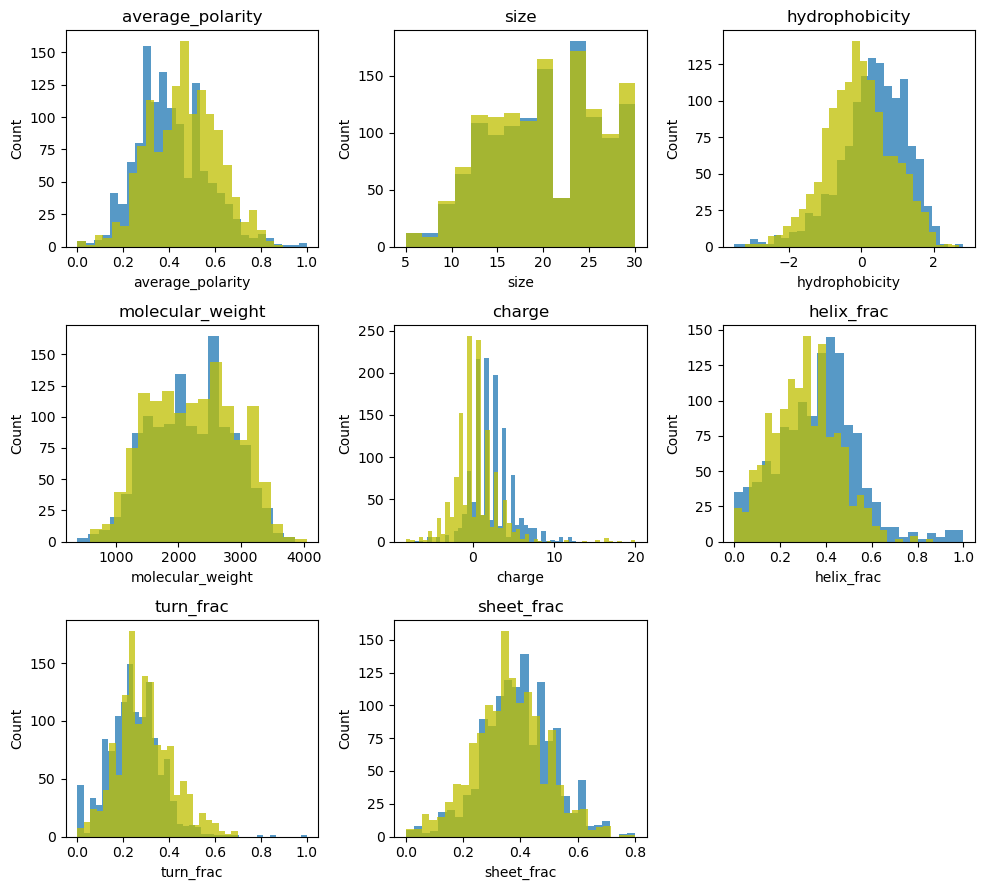

In [114]:
plot_histograms(transformed_train)

In [109]:
# correlation = transformed_train.corr()
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5) 
# plt.show()

In [110]:
features_to_analyze = ['average_polarity', 'size', 'hydrophobicity', 'molecular_weight', 'charge', 'helix_frac', 'turn_frac', 'sheet_frac']

#### Pearson Correlation

Assumes that the variables are normally distributed and have a linear relationship.
Measures the linear association between variables.
Sensitive to outliers.
Appropriate for continuous variables.

In [111]:
from scipy.stats import pearsonr

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Pearson Correlation Coefficient', 'P-Value'])

for feature in features_to_analyze:
    correlation_coefficient, p_value = pearsonr(X_train[feature], X_train['Label'])
    results_df = results_df.append({'Feature': feature, 'Pearson Correlation Coefficient': correlation_coefficient, 'P-Value': round(p_value,3)}, ignore_index=True)

results_df.sort_values(by='P-Value')

,Feature,Pearson Correlation Coefficient,P-Value
0,average_polarity,-0.179979,0.000
2,hydrophobicity,0.212732,0.000
4,charge,0.336732,0.000
5,helix_frac,0.163391,0.000
6,turn_frac,-0.202951,0.000
7,sheet_frac,0.134874,0.000
3,molecular_weight,-0.017423,0.375
1,size,0.000464,0.981


#### Spearman Correlation

Non-parametric measure (does not assume normality or linearity).
Measures the strength and direction of the monotonic (non-linear) relationship between variables.
Less sensitive to outliers.
Appropriate for ordinal or ranked data.

In [112]:
from scipy.stats import spearmanr

# Create an empty DataFrame to store the results
spearman_results_df = pd.DataFrame(columns=['Feature', 'Spearman Correlation Coefficient', 'Spearman P-Value'])

for feature in features_to_analyze:
    # Calculate Spearman correlation
    spearman_corr, spearman_p_value = spearmanr(X_train[feature], X_train['Label'])
    
    # Append the results to the DataFrame
    spearman_results_df = spearman_results_df.append({
        'Feature': feature,
        'Spearman Correlation Coefficient': spearman_corr,
        'Spearman P-Value': round(spearman_p_value, 3)
    }, ignore_index=True)

spearman_results_df.sort_values(by='Spearman P-Value')

,Feature,Spearman Correlation Coefficient,Spearman P-Value
0,average_polarity,-0.196524,0.000
2,hydrophobicity,0.239007,0.000
4,charge,0.402687,0.000
5,helix_frac,0.166763,0.000
6,turn_frac,-0.194047,0.000
7,sheet_frac,0.135912,0.000
3,molecular_weight,-0.015307,0.436
1,size,0.001074,0.956


#### Kendall Tau

Non-parametric measure.
Measures the strength and direction of the concordant and discordant pairs in the data (suitable for non-linear relationships).
Robust to outliers.
Appropriate for ordinal or ranked data.

In [115]:
from scipy.stats import kendalltau

kendall_results_df = pd.DataFrame(columns=['Feature', 'Kendall Tau Correlation Coefficient', 'Kendall Tau P-Value'])

for feature in features_to_analyze:
    kendall_corr, kendall_p_value = kendalltau(X_train[feature], X_train['Label'])
    
    kendall_results_df = kendall_results_df.append({
        'Feature': feature,
        'Kendall Tau Correlation Coefficient': kendall_corr,
        'Kendall Tau P-Value': round(kendall_p_value, 3)
    }, ignore_index=True)

kendall_results_df.sort_values(by='Kendall Tau P-Value')

,Feature,Kendall Tau Correlation Coefficient,Kendall Tau P-Value
0,average_polarity,-0.161542,0.000
2,hydrophobicity,0.195200,0.000
4,charge,0.329383,0.000
5,helix_frac,0.136851,0.000
6,turn_frac,-0.159496,0.000
7,sheet_frac,0.111640,0.000
3,molecular_weight,-0.012501,0.436
1,size,0.000899,0.956


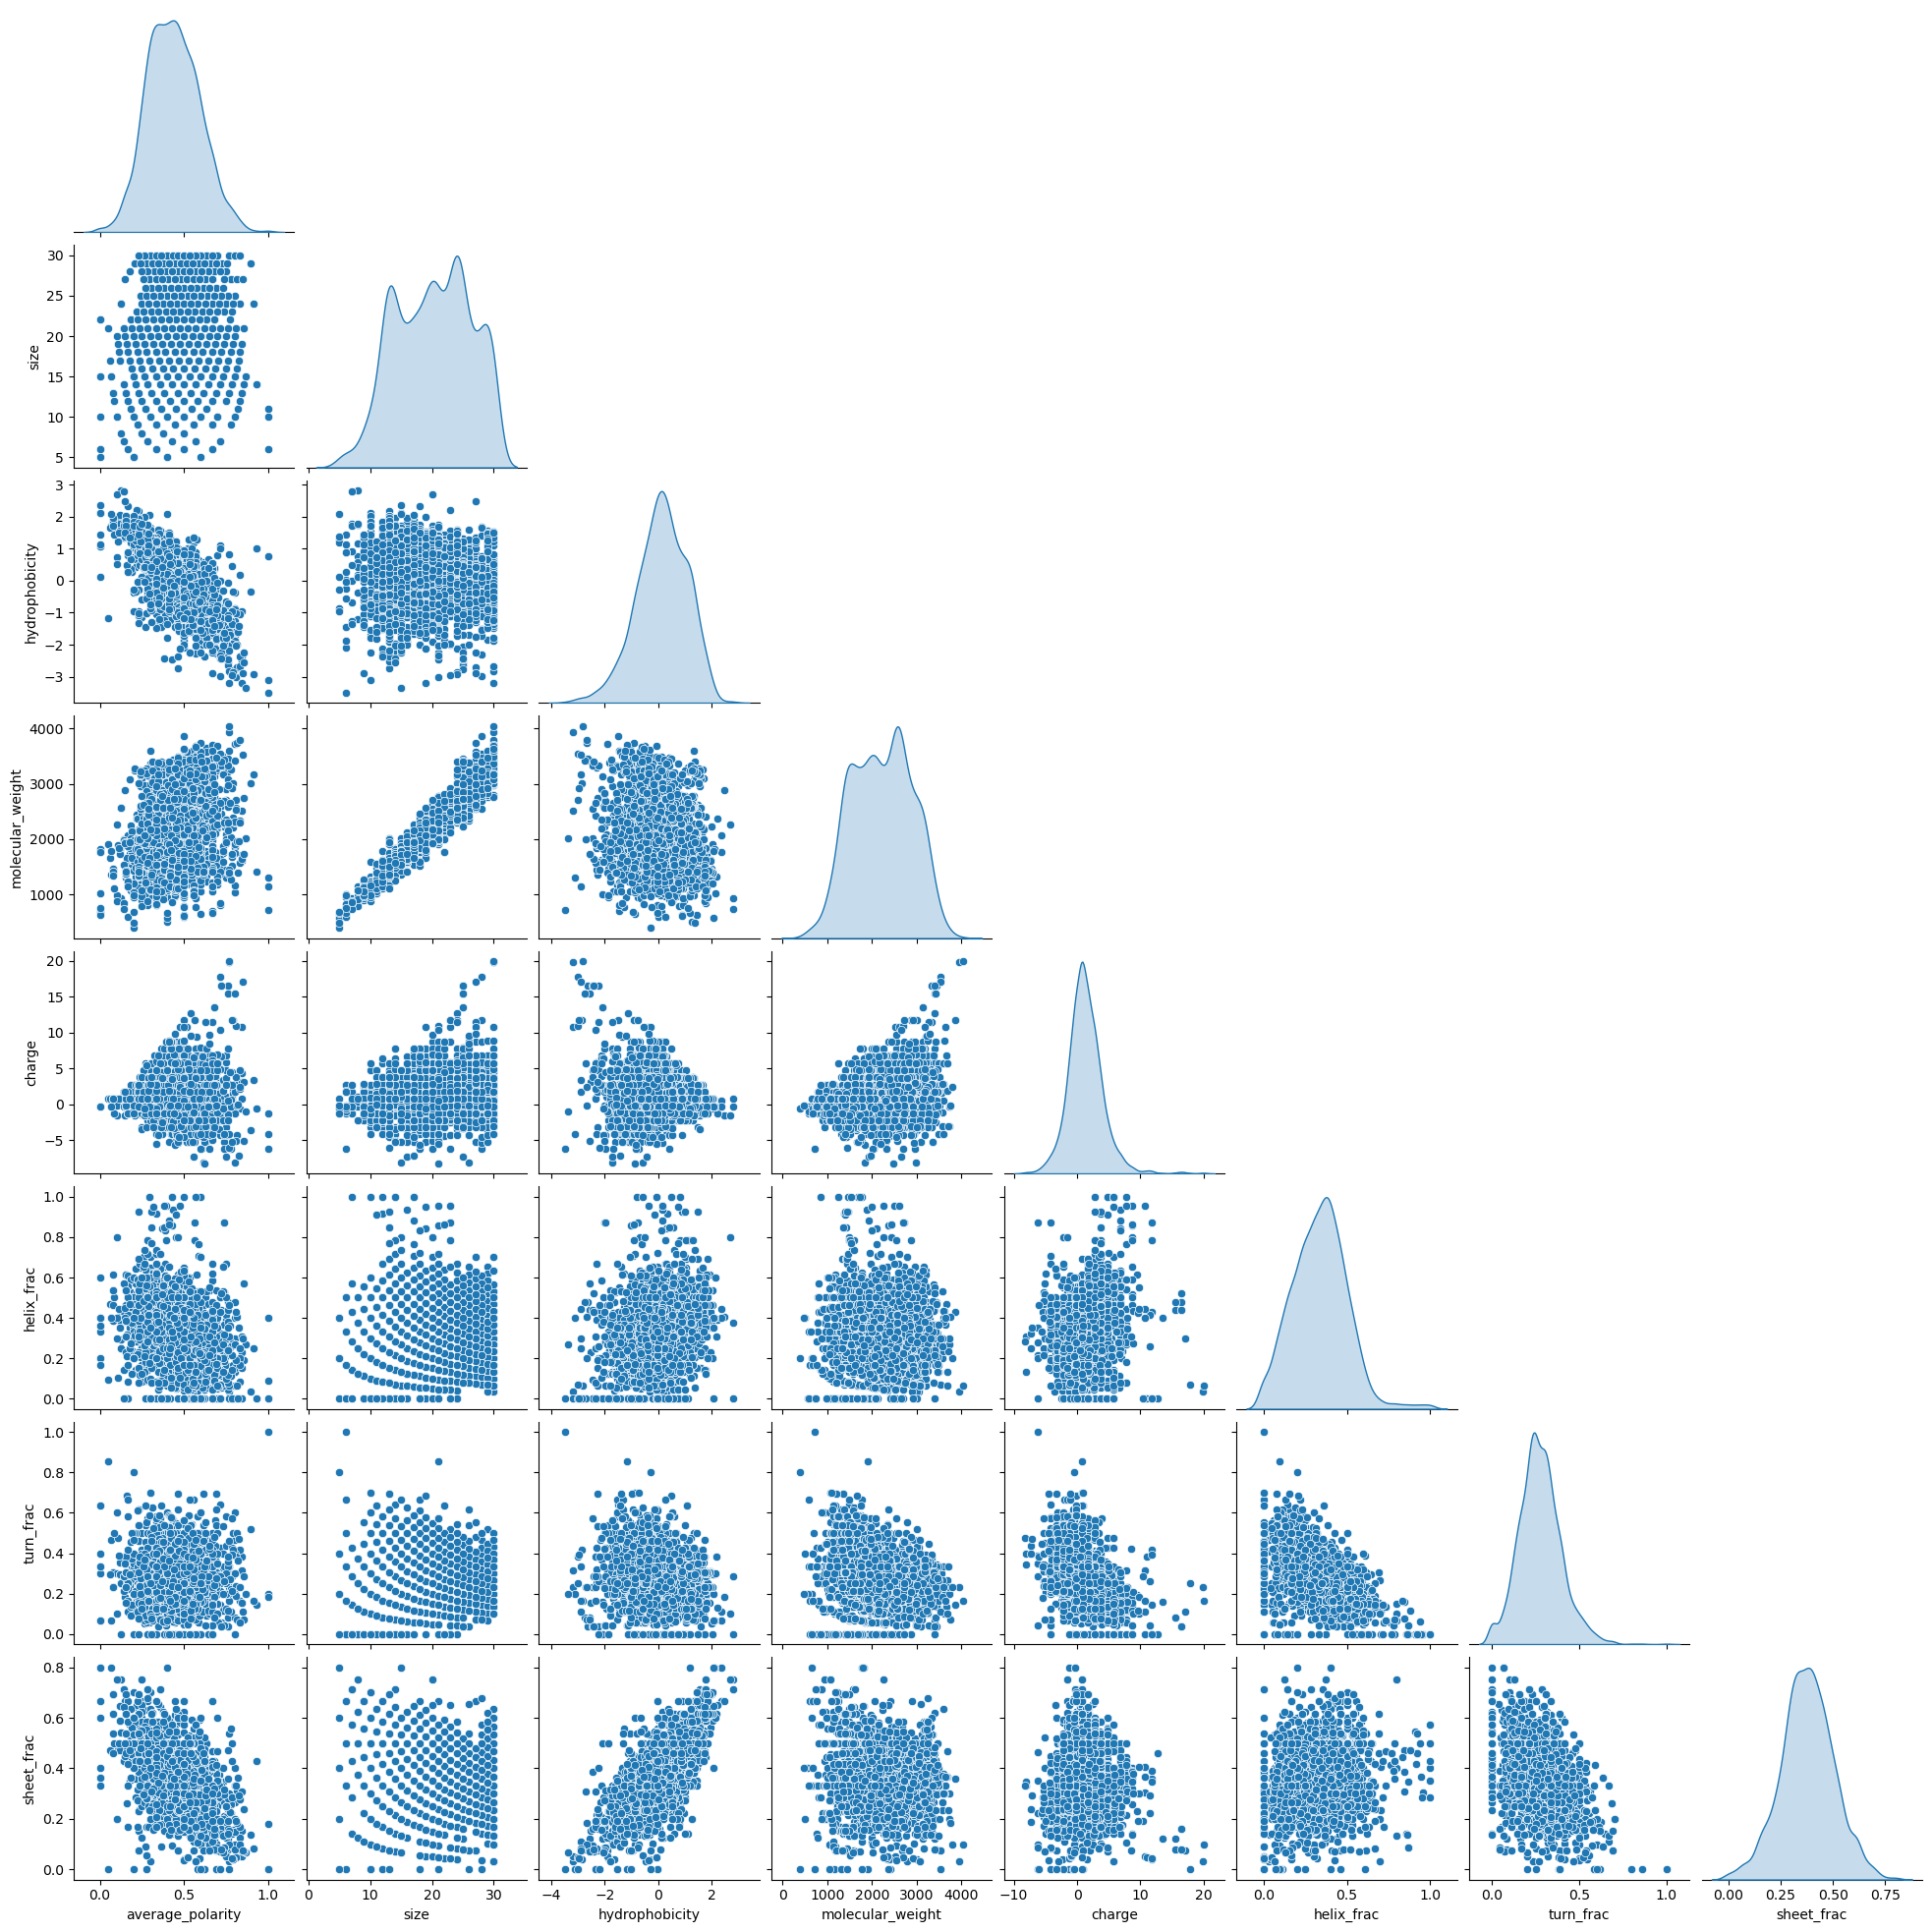

In [116]:
sns.pairplot(data=X_train[features_to_analyze], diag_kind='kde', corner=True)  # 'kde' adds kernel density estimates to the diagonal
plt.show()

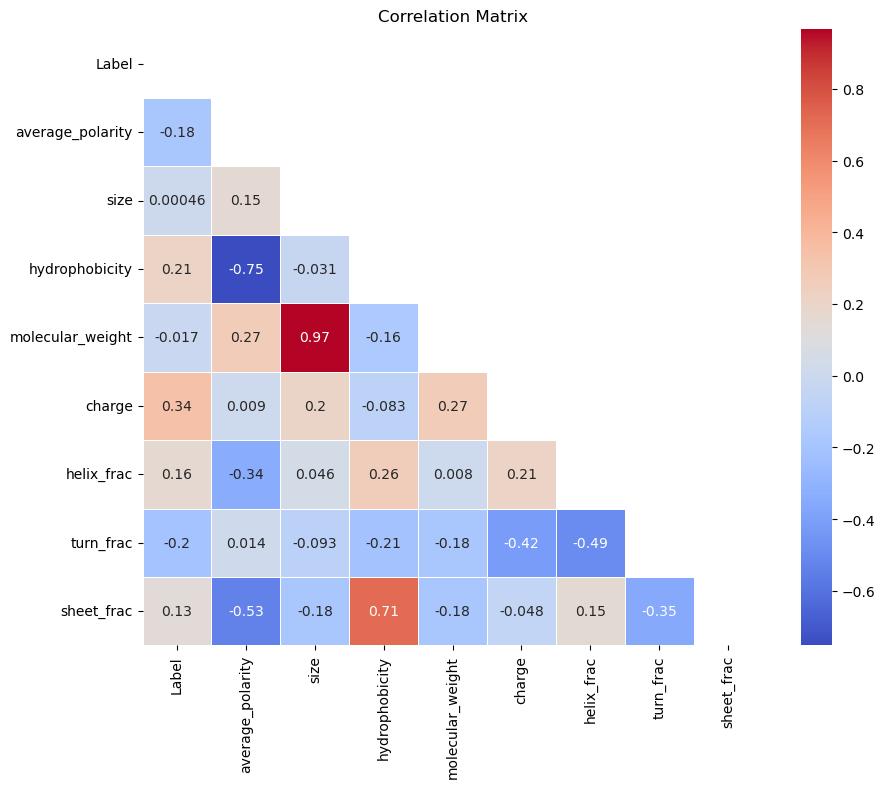

In [117]:
features_to_analyze = ['Label', 'average_polarity', 'size', 'hydrophobicity', 'molecular_weight', 'charge', 'helix_frac', 'turn_frac', 'sheet_frac']


correlation_matrix = X_train[features_to_analyze].corr()

# Create a mask for the upper triangle (including diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

custom_cmap = 'coolwarm'
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, linewidths=.5, mask=mask)
plt.title('Correlation Matrix')
plt.show()

In [118]:
# from scipy.stats import ttest_ind

# features_to_analyze = ['Label', 'average_polarity', 'size', 'hydrophobicity', 'molecular_weight', 'charge', 'helix_frac', 'turn_frac', 'sheet_frac']

# fig, axes = plt.subplots(2, 4, figsize=(16, 8))
# axes = axes.flatten()

# # Create empty lists to store t-test results
# t_test_results = []

# # Loop through each feature and create a box plot with different colors for each 'Label'
# for i, feature in enumerate(features_to_analyze):
#     ax = axes[i]
#     sns.boxplot(x='Label', y=feature, data=X_train, ax=ax)
#     ax.set_title(f'Box Plot: {feature}')
#     ax.set_xlabel('Label')
#     ax.set_ylabel(feature)
    
#     # Perform t-test for each pair of 'Label' categories
#     label_categories = X_train['Label'].unique()
#     for j in range(len(label_categories)):
#         for k in range(j + 1, len(label_categories)):
#             label1 = label_categories[j]
#             label2 = label_categories[k]
            
#             group1 = data[data['Label'] == label1][feature]
#             group2 = data[data['Label'] == label2][feature]
            
#             # Perform the t-test
#             t_stat, p_value = ttest_ind(group1, group2)
            
#             # Store the t-test results
#             t_test_results.append({
#                 'Feature': feature,
#                 'Label 1': label1,
#                 'Label 2': label2,
#                 'T-Statistic': t_stat,
#                 'P-Value': p_value
#             })


# plt.tight_layout()
# plt.show()

# t_test_df = pd.DataFrame(t_test_results)
# print("T-Test Results:")
# t_test_df

#### Check outliers in each group

Create Outlier Indicator Variable

In [ ]:
# Create a binary 'Outlier' variable for each feature indicating the presence of an outlier (1) or not (0)
for feature, outliers in outliers_dict.items():
    data[f'{feature}_Outlier'] = 0
    data.loc[outliers.index, f'{feature}_Outlier'] = 1

Assess Correlation between Outliers and 'Label'

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
data = X_train

# Create empty lists to store test results
feature_list = []
label_list = []
test_statistic_list = []
p_value_list = []
correlation_list = []

# Define a function to perform a t-test or Mann-Whitney U test for each feature's outlier variable
def perform_test(data, feature, label_column, outlier_column):
    label_categories = data[label_column].unique()
    
    for label in label_categories:
        group_with_outlier = data[data[label_column] == label][feature]
        group_without_outlier = data[(data[label_column] == label) & (data[outlier_column] == 0)][feature]
        
        # Perform the test (t-test or Mann-Whitney U test)
        if len(group_with_outlier) >= 5 and len(group_without_outlier) >= 5:
            # Use t-test for normally distributed data
            t_statistic, p_value = ttest_ind(group_with_outlier, group_without_outlier)
        else:
            # Use Mann-Whitney U test for non-normally distributed data or small sample sizes
            U_statistic, p_value = mannwhitneyu(group_with_outlier, group_without_outlier, alternative='two-sided')
        
        # Determine if the result is statistically significant
        is_significant = p_value < 0.05
        
        # Append the results to the lists
        feature_list.append(feature)
        label_list.append(label)
        test_statistic_list.append(t_statistic if len(group_with_outlier) >= 5 and len(group_without_outlier) >= 5 else U_statistic)
        p_value_list.append(p_value)
        correlation_list.append("Yes" if is_significant else "No")

# Loop through each feature's outlier variable and perform t-test or Mann-Whitney U test
label_column = 'Label'
for feature in features_to_analyze:
    outlier_column = f'{feature}_Outlier'
    perform_test(data, feature, label_column, outlier_column)

results_df = pd.DataFrame({
    'Feature': feature_list,
    'Label': label_list,
    'Test Statistic': test_statistic_list,
    'P-Value': p_value_list,
    'Correlation with Label': correlation_list
})

print(results_df)

Summary:
Outliers from charge and turn_frac is correlated with Label.

In [ ]:
import scipy.stats as stats

ks_results_df = pd.DataFrame(columns=['Feature', 'KS Statistic', 'KS P-Value', 'Is Normal'])

# Set significance level (alpha)
alpha = 0.05

for feature in features_to_analyze:
    ks_statistic, ks_p_value = stats.kstest(X_train[feature], 'norm')
    is_normal = ks_p_value >= alpha
    ks_results_df = ks_results_df.append({
        'Feature': feature,
        'KS Statistic': ks_statistic,
        'KS P-Value': ks_p_value,
        'Is Normal': is_normal
    }, ignore_index=True)

print(ks_results_df)

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(X_train[features_to_analyze])

# Set significance level (alpha)
alpha = 0.05

# Interpret the result
if p > alpha:
    print("The data follows a normal distribution (fail to reject H0)")
else:
    print("The data does not follow a normal distribution (reject H0)")

# Print the test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-Value: {p}")

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Your dataset (replace 'data' with your actual dataset)
data = X_train[features_to_analyze]

# Create a Q-Q plot
sm.qqplot(data, line='s')

# Add a reference line for a normal distribution (optional)
plt.title("Q-Q Plot")
plt.show()

In [ ]:
import statsmodels.api as sm
    
# Create separate Q-Q plots for each feature in 'features_to_analyze'
for feature_name in features_to_analyze:
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
    sm.qqplot(X_train[feature_name], line='s')
    plt.title(f'Q-Q Plot for {feature_name}')
    plt.show()


## Functions

In [ ]:
# # Get physicochemical properties
# class Property_Transformer(object):
    
#     def __init__(self):
#         # Polarity values for amino acids (1 for polar, 0 for nonpolar)
#         self.polarity_values = {'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0, 'H': 1, 'I': 0,
#                                 'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1, 'T': 1, 'W': 0, 'Y': 1, 'V': 0}
        
#         # reference: charge_values = {'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5, 'other aa':0}, charge result is the sum of all the values

        
#     def fit(self, X, y=None):
#         pass # No training needed
        
#     def transform(self, X, y=None):
#         X['average_polarity'] = X['Sequence'].apply(self.calculate_average_polarity)
#         X['size'] = X['Sequence'].apply(len)
#         X['hydrophobicity'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy()) 
#         X['molecular_weight'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())
#         X['charge'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).charge_at_pH(7.0))
#         X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
#         X['second_structure'] = X['Sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction())
#         X[['helix_frac', 'turn_frac', 'sheet_frac']] = X['second_structure'].apply(pd.Series) # split the 'second_structure' column into 3 new columns
        
#         return X
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)
    
#     def calculate_average_polarity(self, sequence):
#         # Calculate polarity for each amino acid in the sequence
#         polarities = [self.polarity_values.get(aa, 0) for aa in sequence]
#         average_polarity = sum(polarities) / len(sequence)
#         return average_polarity

In [ ]:
# train['Features'] = None  # Create a new column to store the features

# for index, row in train.iterrows():
#     protein_sequence = row['Sequence']
#     result = CalculateCTD(protein_sequence)

#     # Assign the entire dictionary to the 'Features' column
#     train.at[index, 'Features'] = result

# # Expand the 'Features' column into separate feature columns
# train = pd.concat([train, train['Features'].apply(pd.Series)], axis=1)

# # Drop the original 'Features' column if needed
# train = train.drop(columns=['Features'])

In [ ]:
# class CTD_Transformer(object):
    
#     def __init__(self):
#         pass  # No initialization needed
    
#     def fit(self, X, y=None):
#         pass  # No training needed
        
#     def transform(self, X, y=None):
#         X['Features'] = X['Sequence'].apply(self.calculate_ctd_features)

#         # Expand the 'Features' column into separate feature columns
#         X = pd.concat([X, X['Features'].apply(pd.Series)], axis=1)

#         # Drop the original 'Features' column if needed
#         X = X.drop(columns=['Features'])
        
#         return X
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)
    
#     def calculate_ctd_features(self, sequence):
#         # Use propy.CTD.CalculateD to get features for the given sequence
#         result = CalculateCTD(sequence)
#         return result


In [ ]:
# def plot_histograms(dataframe):
#     sns.set(style="darkgrid")
#     dataframe = dataframe.drop(columns=['Sequence', 'second_structure'])
#     features = dataframe.columns.tolist()
#     features.remove('Label')

#     # Set the number of subplots and their arrangement
#     num_subplots = len(features)
#     num_cols = 3  # You can change the number of columns based on your preference
#     num_rows = (num_subplots - 1) // num_cols + 1

#     # Set the size of the figure
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=150)

#     # Flatten axes in case there is only one row
#     axes = axes.flatten()

#     # Loop through each column and plot the histogram
#     for i, column in enumerate(features):
#         ax = axes[i]
#         sns.histplot(data=dataframe[dataframe.Label==1], x=column, ax=ax, kde=True, color='blue')
#         sns.histplot(data=dataframe[dataframe.Label==0], x=column, ax=ax, kde=True, color='red')
#         ax.set_title(f'Histogram of {column}')
#         ax.set_xlabel(column)
#         ax.set_ylabel('Count')

#     # remove empty subplots
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])
    
#     # Adjust layout to prevent overlapping
#     plt.tight_layout()
#     plt.show()

In [ ]:
#  plot_histograms(train)

# correlation = train.corr()
# plt.figure(figsize=(12, 4), dpi=150)
# sns.heatmap(correlation,cmap='coolwarm', annot=True) 
# plt.show()

In [ ]:
# # Assuming 'X' is your feature matrix containing the top 30 features
# # and 'y' is your target variable

# # Extract the top 30 features from your DataFrame
# X_top_50 = X_train[top_50_features_list]

# # Add a constant term for the intercept
# X_top_50 = sm.add_constant(X_top_50)

# # Calculate VIF for each feature
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_top_50.columns
# vif_data["VIF"] = [variance_inflation_factor(X_top_50.values, i) for i in range(X_top_50.shape[1])]
# print(vif_data)

# # Identify features with high VIF
# high_vif_features = vif_data[vif_data["VIF"] >= 5]["Feature"].tolist()
# high_vif_features.remove('const')
# print("Features with high VIF:", high_vif_features)